In [129]:
import math
from dataclasses import dataclass, field, InitVar, asdict
from graphviz import Digraph


@dataclass(unsafe_hash=True, eq=True)
class Value:
    data: float
    prev: set = field(compare=False, repr=False, default_factory=set)
    op: str = field(compare=False, repr=False, default='')
    label: str = field(compare=False, default='')
    grad: float = field(compare=False, default=0.0)

    def __post_init__(self, ):
        if self.op not in ('', '+', '*', 'tanh'):
            raise ValueError("op not in ('', '+', '*')")
        if not self.label:
            if self.op in ('+', '*'):
                label = self.op.join(p.label for p in self.prev)
                self.label = f"({label})"
            if self.op == 'tanh':
                self.label = f"tanh({next(iter(self.prev)).label})"
        self.prev = set(self.prev)

    def __add__(self, other):
        return Value(self.data + other.data, prev=(self, other), op='+')
        
    def __mul__(self, other):
        return Value(self.data * other.data, prev=(self, other), op='*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, prev={self}, op='tanh')
        return out

    
    def viz(self):
        return Value._draw_dot(self)

    @staticmethod
    def _draw_dot(v: Value, rankdir='TD'):
        dot = Digraph(format='svg', 
                      graph_attr={'rankdir': rankdir}
                     )
        nodes, edges = v._trace()
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"{{ {n.op} | {n.label} | {n.data:.4f} (grad {n.grad}) }}", shape='record')
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)))
        return dot

    def _trace(self):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
        build(self)
        return nodes, edges


v = Value(2.0, label='a') * Value(3.0, label='b') + Value(1.0, label='c')
v2 = v.tanh()
assert v.data == 7.0
assert v.prev == {Value(data=1.0), Value(data=6.0)}

In [130]:
v

Value(data=7.0, label='((a*b)+c)', grad=0.0)

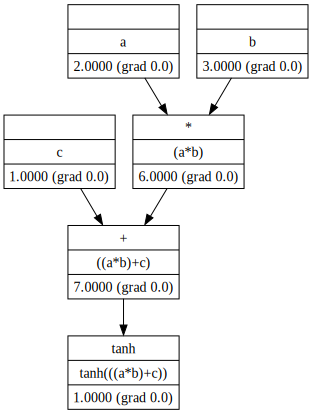

In [131]:
v2.viz()